<a href="https://colab.research.google.com/github/Rohit-Madhesiya/Long-Term-Agentic-Memory-with-LangGraph/blob/main/Email_Assistant_with_Semantic_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')

In [87]:
!pip install langchain_openai langgraph

In [88]:
profile={
    "name":"Rohit",
    "full_name":"Rohit Gupta",
    "user_profile_background":"Assistant Systems Engineer working as a Fresher in TCS"
}

In [89]:
prompt_instructions={
    "triage_rules":{
        "ignore":"Marketing newsletters, spam emails, mass company announcements",
        "notify":"Team member out sick, build system notifications, project status updates",
        "respond":"Direct questions from team members, meeting requests,critical bug reports"
    },
    "agent_instructions":"Use these tools when appropriate to help manage Rohit's tasks efficiently"
}

In [90]:
email={
    "from":"Rahul <rahul@tcs.com>",
    "to":"Rohit Gupta <guptarohit@tcs.com",
    "subject":"Quick question about API documentation",
    "body":"""
    Hi Rohit,
    I was reviewing the API documentations for the new authentication service and noticed a few endpoints seem to be missing from the specs.
    Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I am looking at:
    - /auth/login
    - /auth/validate

    Thanks!
    Rahul
    """
}

In [91]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [92]:
llm=init_chat_model("openai:gpt-4o-mini")

In [93]:
class Router(BaseModel):
  """
  Analyze the unread email and route it according to its content
  """
  reasoning:str=Field(
      description="Step-by-step reasoning behind the classification"
  )
  classification:Literal["ignore","respond","notify"]=Field(
      description="The classification of an email: 'ignore' for irrevelant emails, "
      "'notify' for important information that doesn't nees a response, "
      "'respond' for emails that need a reply",
  )


In [94]:
llm_router=llm.with_structured_output(Router)

In [95]:
from langchain.prompts import PromptTemplate


system_prompt=PromptTemplate(
    input_variables=["profile","prompt_instructions"],
    template="Your system message template here, using {profile} and {prompt_instructions}"
)
user_prompt=PromptTemplate(
    input_variables=['email'],
    template="Your user message template here, using {email}"
)

In [96]:
from langchain.tools import tool

In [97]:
@tool
def write_email(to:str,subject:str,content:str)->str:
  """Write and send en email"""
  return f"Email sent to {to} with subject '{subject}' and content '{content}'"

In [98]:
@tool
def schedule_meeting(attendees:str,subject:str,duration:int,day:str)->str:
  """Schedule a calendar meeting"""
  return f"Meeting '{subject}' scheduled for {day} with {len(attendees)} attendees"

In [99]:
@tool
def check_calendar_availability(day:str)->str:
  """Check calendar availability for a given day"""
  return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

Tools for managing memory

In [100]:
from langgraph.store.memory import InMemoryStore

In [101]:
store=InMemoryStore(
    index={
        "embed":"openai:text-embedding-3-small"
    }
)

In [102]:
!pip install langmem

In [103]:
from langmem import create_manage_memory_tool,create_search_memory_tool

In [104]:
manage_memory_tool=create_manage_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

search_memory_tool=create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [105]:
print(manage_memory_tool.name)

manage_memory


In [106]:
print(manage_memory_tool.description)

Create, update, or delete persistent MEMORIES to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [107]:
manage_memory_tool.args

{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Content'},
 'action': {'default': 'create',
  'enum': ['create', 'update', 'delete'],
  'title': 'Action',
  'type': 'string'},
 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Id'}}

In [108]:
search_memory_tool.name

'search_memory'

In [109]:
search_memory_tool.description

'Search your long-term memories for information relevant to your current context.'

In [110]:
search_memory_tool.args

{'query': {'title': 'Query', 'type': 'string'},
 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'},
 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'},
 'filter': {'anyOf': [{'type': 'object'}, {'type': 'null'}],
  'default': None,
  'title': 'Filter'}}

In [111]:
agent_system_prompt_memory="""
<Role>
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about
{name} performing as well as possible
</Role>

<Tools>
You have access to the following tools to help manage {name}'s communications and schedule:
1. write_email(to,subject,content) - Send emails to specified recipients
2. schedule_meeting(attendees,subject,duration,day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about Contacts, actions, dicussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</Tools>

<Instructions>
{instructions}
</Instructions>
"""

In [112]:
def create_prompt(state):
  return [{
      "role":"system",
      "content":agent_system_prompt_memory.format(
          instructions=prompt_instructions['agent_instructions'],
          **profile
      )
  }]+state['messages']

In [113]:
from langgraph.prebuilt import create_react_agent

In [114]:
tools=[
    write_email,
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]

In [115]:
!pip install langchain_groq

In [116]:
from langchain_groq import ChatGroq
os.environ['GROQ_API_KEY']=userdata.get('GROQ_API_KEY')
model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [117]:
response_agent=create_react_agent(
    model=model,
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [118]:
config={
    "configurable":{'langgraph_user_id':"session123"}
}

In [119]:
response=response_agent.invoke(
    {"messages":[{"role":"user","content":"Rahul is my friend"}]},
    config=config
)

In [120]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

Rahul is my friend
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_005n)
 Call ID: call_005n
  Args:
    action: create
    content: {"name": "Rahul", "relationship": "friend"}
================================= Tool Message =================================
Name: manage_memory

created memory 22f14197-af40-4d57-83dd-f2e278b68f17
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_1rg7)
 Call ID: call_1rg7
  Args:
    action: create
    content: {"name": "Rahul", "relationship": "friend"}
================================= Tool Message =================================
Name: manage_memory

created memory 7906f4a9-ee78-40f2-aa3f-57eb645905cd
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_dvge)
 Call ID: call_dvge


In [121]:
response=response_agent.invoke(
    {"messages":[{"role":"user","content":"Who is Rahul?"}]},
    config=config
)

In [122]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

Who is Rahul?
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_qebv)
 Call ID: call_qebv
  Args:
    query: Rahul
================================= Tool Message =================================
Name: search_memory

[{"namespace": ["email_assistant", "session123", "collection"], "key": "7906f4a9-ee78-40f2-aa3f-57eb645905cd", "value": {"content": "{\"name\": \"Rahul\", \"relationship\": \"friend\"}"}, "created_at": "2025-03-24T16:34:27.609436+00:00", "updated_at": "2025-03-24T16:34:27.609442+00:00", "score": 0.5347892568097516}, {"namespace": ["email_assistant", "session123", "collection"], "key": "22f14197-af40-4d57-83dd-f2e278b68f17", "value": {"content": "{\"name\": \"Rahul\", \"relationship\": \"friend\"}"}, "created_at": "2025-03-24T16:34:25.208122+00:00", "updated_at": "2025-03-24T16:34:25.208127+00:00", "score": 0.5347888597734112}, {

In [123]:
store.list_namespaces()

[('email_assistant', 'session123', 'collection')]

In [124]:
store.search(('email_assistant',"session123","collection"))

[Item(namespace=['email_assistant', 'session123', 'collection'], key='22f14197-af40-4d57-83dd-f2e278b68f17', value={'content': '{"name": "Rahul", "relationship": "friend"}'}, created_at='2025-03-24T16:34:25.208122+00:00', updated_at='2025-03-24T16:34:25.208127+00:00', score=None),
 Item(namespace=['email_assistant', 'session123', 'collection'], key='7906f4a9-ee78-40f2-aa3f-57eb645905cd', value={'content': '{"name": "Rahul", "relationship": "friend"}'}, created_at='2025-03-24T16:34:27.609436+00:00', updated_at='2025-03-24T16:34:27.609442+00:00', score=None),
 Item(namespace=['email_assistant', 'session123', 'collection'], key='d80df7be-174e-4ad7-81da-96ac3304ce96', value={'content': '{"name": "Rahul", "relationship": "friend"}'}, created_at='2025-03-24T16:34:30.480970+00:00', updated_at='2025-03-24T16:34:30.480976+00:00', score=None)]

In [125]:
store.search(("email_assistant","session123","collection"),query='Rahul')

[Item(namespace=['email_assistant', 'session123', 'collection'], key='7906f4a9-ee78-40f2-aa3f-57eb645905cd', value={'content': '{"name": "Rahul", "relationship": "friend"}'}, created_at='2025-03-24T16:34:27.609436+00:00', updated_at='2025-03-24T16:34:27.609442+00:00', score=0.5347892568097516),
 Item(namespace=['email_assistant', 'session123', 'collection'], key='22f14197-af40-4d57-83dd-f2e278b68f17', value={'content': '{"name": "Rahul", "relationship": "friend"}'}, created_at='2025-03-24T16:34:25.208122+00:00', updated_at='2025-03-24T16:34:25.208127+00:00', score=0.5347888597734112),
 Item(namespace=['email_assistant', 'session123', 'collection'], key='d80df7be-174e-4ad7-81da-96ac3304ce96', value={'content': '{"name": "Rahul", "relationship": "friend"}'}, created_at='2025-03-24T16:34:30.480970+00:00', updated_at='2025-03-24T16:34:30.480976+00:00', score=0.5347690747462783)]

Rest of the Agent

In [126]:
  from langgraph.graph import add_messages

  class State(TypedDict):
    email_input:dict
    messages:Annotated[list,add_messages]

In [127]:
from langgraph.graph import START,END,StateGraph
from langgraph.types import Command
from typing import Literal

In [128]:
def triage_router(state:State)->Command[Literal['response_agent','__end__']]:
  author=state['email_input']['author']
  to=state['email_input']['to']
  subject=state['email_input']['subject']
  email_thread=state['email_input']['email_thread']

  system_prompt=PromptTemplate(
    input_variables=["profile","prompt_instructions"],
    template="Your system message template here, using {profile} and {prompt_instructions}"
  )
  email_input={
      author:author,
      to:to,
      subject:subject,
      email_thread:email_thread
  }
  user_prompt=PromptTemplate(
    input_variables=['email'],
    template="Your user message template here, using {email}"
  )

  result=llm_router.invoke(
    [
        {'role':"system",'content':system_prompt.format(profile=profile,prompt_instructions=prompt_instructions)},
        {'role':"user",'content':user_prompt.format(email=email_input)}
    ]
  )

  if result.classification=='respond':
    print("📧 Classification: RESPOND - This email requires a response")
    goto ="response_agent"
    update={
        "messages":[{
            "role":"user",
            "content":f"Respond to the email {state['email_input']}"
        }]
    }
  elif result.classification=='ignore':
    print("🚫 Classification: IGNORE - This email can be safely ignored")
    update=None
    goto=END
  elif result.classification=='notify':
    print("🔔 Classification: NOTIFY - This email contains important information")
    update=None
    goto=END
  else:
    raise ValueError(f"Invalid classification: {result.classification}")

  return Command(goto=goto,update=update)

Email Agent

In [129]:
email_agent=StateGraph(State)
email_agent=email_agent.add_node(triage_router)
email_agent=email_agent.add_node("response_agent",response_agent)
email_agent=email_agent.add_edge(START,"triage_router")
email_agent=email_agent.compile(store=store)

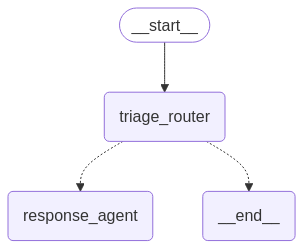

In [130]:
email_agent

In [131]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Rohit Gupta <guptarohit@tcs.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi Rohit,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [132]:
response=email_agent.invoke(
    {"email_input":email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [133]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Rohit Gupta <guptarohit@tcs.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Rohit,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_zgm3)
 Call ID: call_zgm3
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for reaching out and for pointing that out. I’ll check with the team regarding the missing endpoints (/auth/refresh and /auth/validat

Memory Check

In [134]:
email_input={
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Rohit Gupta <guptarohit@tcs.com>",
    "subject": "Follow up",
    "email_thread": """Hi Rohit,

  Any update on my previous ask?""",
}

In [138]:
response=email_agent.invoke({
    "email_input":email_input
    },
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [139]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Rohit Gupta <guptarohit@tcs.com>', 'subject': 'Follow up', 'email_thread': 'Hi Rohit,\n\n  Any update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_hg8g)
 Call ID: call_hg8g
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Follow up
    content: Hi Alice,

Thank you for your follow-up email. Rohit will review your request and provide an update shortly.

Best regards,
[Your Name]
Executive Assistant to Rohit Gupta
================================= Tool Message =================================
Name: write_email

Email sent to Alice Smith <alice.smith@company.com> with subject 'Re: Follow up' and content 'Hi Alice,

Thank you for your follow-up email. Rohit will review your request and provide an update shortly.

Best r